<a href="https://colab.research.google.com/github/cinnaavox/CIFAR-10-Image-Classification-with-ResNet50/blob/main/CV_Project_Version_2(all_data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🧩 Block 1 – Projekttitel & kurze Einordnung

### CIFAR-10 Bildklassifikation mit ResNet50 (kompletter Datensatz)

In diesem Projekt möchte ich ein Bildklassifikationsmodell für den CIFAR-10 Datensatz aufbauen und trainieren.  
Im Gegensatz zu früheren Experimenten arbeite ich hier bewusst mit dem **kompletten Trainingsdatensatz** (50.000 Bilder), um zu sehen, wie sich ein größeres Datenvolumen auf das Training eines vortrainierten Modells auswirkt.

Mein Ziel ist es:

- den CIFAR-10 Datensatz zu laden und zu verstehen,
- die Bilder sinnvoll vorzubereiten,
- ein Transfer-Learning-Modell mit **ResNet50** aufzubauen,
- das Modell in zwei Phasen zu trainieren (erst nur den Kopf, dann Fine-Tuning),
- und am Ende die Performance auf den Testdaten auszuwerten.


## 🧩 Block 2 – Setup & Imports

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Seeds für etwas reproduzierbareres Verhalten
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow-Version:", tf.__version__)

TensorFlow-Version: 2.19.0


Hier importiere ich alle Bibliotheken, die ich für das Projekt brauche:

+ tensorflow und keras für das Modell und das Training,

+ cifar10, um den Datensatz direkt zu laden,

+ ResNet50 als vortrainiertes Basis-Modell für Transfer Learning,

+ to_categorical für das One-Hot-Encoding der Labels,

+ matplotlib für Visualisierungen.

Mit den gesetzten Seeds versuche ich, das Verhalten beim Training ein bisschen reproduzierbarer zu machen, auch wenn es bei GPUs und großen Modellen nie 100 % identisch ist.

## 🧩 Block 3 – CIFAR-10 komplett laden

In [ ]:
# CIFAR-10 Datensatz laden (komplette Trainingsdaten)
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Trainingsdaten:", x_train.shape, y_train.shape)
print("Testdaten:", x_test.shape, y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 30s 0us/step
Trainingsdaten: (50000, 32, 32, 3) (50000, 1)
Testdaten: (10000, 32, 32, 3) (10000, 1)


CIFAR-10 wird hier direkt über cifar10.load_data() geladen.
Der Datensatz enthält:

+ 50.000 Trainingsbilder und

+ 10.000 Testbilder,
jeweils in der Form 32 × 32 × 3 (also kleine RGB-Bilder).

In diesem Projekt nutze ich diesmal bewusst den kompletten Trainingsdatensatz,
um das Modell mit möglichst vielen Beispielen zu füttern.

## 🧩 Block 4 – Kurzer Blick auf ein paar Beispielbilder

Beispiel-Label (Rohwert): 6
Entspricht Klasse: frog


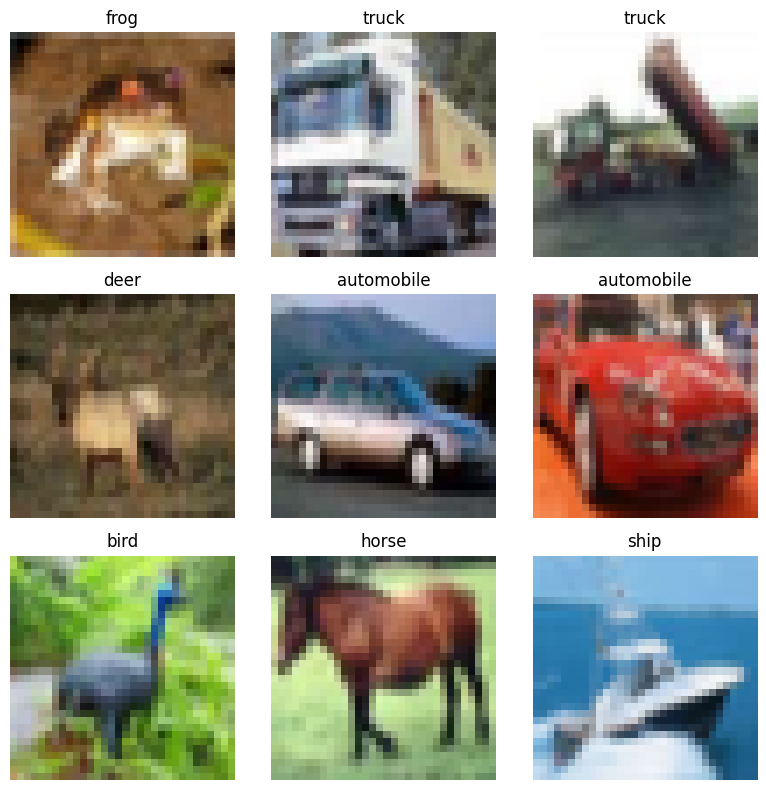

In [ ]:
# Klassenlabels laut CIFAR-10 Dokumentation
class_names = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Labels flach machen, damit sie einfacher zu handhaben sind
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

print("Beispiel-Label (Rohwert):", y_train_flat[0])
print("Entspricht Klasse:", class_names[int(y_train_flat[0])])

# 3x3-Beispiele aus den Trainingsdaten anzeigen
plt.figure(figsize=(8, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i])
    plt.title(class_names[int(y_train_flat[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

Bevor ich mit dem eigentlichen Modell starte, verschaffe ich mir einen visuellen Eindruck vom Datensatz.

CIFAR-10 enthält farbige Bilder aus zehn Klassen, zum Beispiel airplane, dog, cat, ship, truck.
Die Bilder sind sehr klein (32×32 Pixel), was die Aufgabe durchaus anspruchsvoll macht,
vor allem bei ähnlichen Kategorien wie „automobile“ und „truck“.

Die kleine Vorschau mit 3×3 Bildern hilft mir, ein Gefühl für die Bildqualität und die Klassenverteilung zu bekommen.

## 🧩 Block 5 – Daten vorbereiten & tf.data-Pipelines

In [ ]:
# 🧹 Preprocessing für das komplette CIFAR-10-Set

# 1️⃣ Labels flach machen (von (50000, 1) -> (50000,))
y_train_flat = y_train.flatten()
y_test_flat = y_test.flatten()

# 2️⃣ Bilder in float32 konvertieren und normalisieren (0–255 -> 0–1)
x_train_norm = x_train.astype("float32") / 255.0
x_test_norm = x_test.astype("float32") / 255.0

# 3️⃣ One-Hot-Encoding der Labels (10 Klassen)
y_train_cat = to_categorical(y_train_flat, 10)
y_test_cat = to_categorical(y_test_flat, 10)

print("Train-Bilder (normiert):", x_train_norm.shape)
print("Train-Labels (One-Hot):", y_train_cat.shape)
print("Test-Bilder (normiert):", x_test_norm.shape)
print("Test-Labels (One-Hot):", y_test_cat.shape)

# 4️⃣ tf.data-Pipeline für effizienteres Training in Colab
batch_size = 64  # bewusst etwas größer, aber noch colab-freundlich

train_ds = (
    tf.data.Dataset
    .from_tensor_slices((x_train_norm, y_train_cat))
    .shuffle(buffer_size=50000)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    tf.data.Dataset
    .from_tensor_slices((x_test_norm, y_test_cat))
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

Train-Bilder (normiert): (50000, 32, 32, 3)
Train-Labels (One-Hot): (50000, 10)
Test-Bilder (normiert): (10000, 32, 32, 3)
Test-Labels (One-Hot): (10000, 10)


### Datenvorbereitung

In diesem Schritt bereite ich die CIFAR-10 Daten so vor, dass sie gut in ein neuronales Netz passen:

- Zuerst flache ich die Labels ab, damit jeder Eintrag ein einfacher Integer ist (0–9).
- Die Bilder konvertiere ich in `float32` und skaliere die Pixelwerte von 0–255 auf den Bereich **0–1**.  
  Das hilft dem Modell beim Lernen, weil die Werte kleiner und stabiler sind.
- Anschließend wandle ich die Labels in **One-Hot-Vektoren** um, z. B. `[0,0,0,0,0,0,1,0,0,0]` für „frog“.

Da ich hier mit **50.000 Trainingsbildern** arbeite, nutze ich außerdem eine `tf.data`-Pipeline:
- `shuffle()` durchmischt die Daten,
- `batch()` fasst sie in Pakete von 64 Bildern zusammen,
- `prefetch()` sorgt dafür, dass die GPU/TPU besser ausgelastet wird.

Damit ist das Dataset nicht nur inhaltlich vorbereitet, sondern auch technisch besser für längeres Training in Google Colab aufgestellt.


## 🧩 Block 6 – ResNet50-Basis + eigener Kopf (neues Modell)

In [ ]:
# 🔧 ResNet50-Basismodell + Klassifikationskopf für CIFAR-10

# 1) ResNet50 als Feature-Extractor laden (vortrainiert auf ImageNet)
base_model = ResNet50(
    weights="imagenet",
    include_top=False,          # ohne ursprünglichen Klassifikationskopf
    input_shape=(32, 32, 3)     # CIFAR-10 Bildgröße
)

# 2) Basismodell zunächst einfrieren (nur Kopf trainiert)
base_model.trainable = False

# 3) Eigenen Kopf definieren (Functional API)
inputs = Input(shape=(32, 32, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = models.Model(inputs, outputs)

# 4) Modell kompilieren
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 1, 1, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,129,354 (92.05 MB)

 Trainable params: 541,642 (2.07 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### Modellarchitektur: ResNet50 + eigener Klassifikationskopf

Als Basismodell verwende ich **ResNet50**, das bereits auf dem großen ImageNet-Datensatz vortrainiert wurde.
Ich lade es ohne den ursprünglichen Klassifikationskopf (`include_top=False`), weil ich meine eigene Ausgabe für CIFAR-10 definieren möchte.

Die Architektur sieht grob so aus:

- **ResNet50 (eingefroren)** als Feature-Extractor  
- `GlobalAveragePooling2D`, um die Feature-Maps in einen Vektor zu überführen
- ein erster Dense-Layer mit 256 Neuronen (ReLU)
- ein zweiter Dense-Layer mit 64 Neuronen (ReLU)
- ein Output-Layer mit 10 Neuronen und `softmax` für die 10 CIFAR-10 Klassen

In dieser ersten Trainingsphase ist `base_model.trainable = False` gesetzt.
Das bedeutet: ResNet50 selbst wird noch nicht angepasst, sondern liefert nur Merkmalsrepräsentationen.
Trainiert wird zunächst nur der neu hinzugefügte Kopf.

Als Loss-Funktion verwende ich `categorical_crossentropy` (weil ich One-Hot-Labels habe),
und als Optimierer `Adam` mit einer Lernrate von `1e-3` für den Einstieg.

## 🧩 Block 7 – Training des Klassifikationskopfs (Head only)

In [ ]:
# 🧠 Phase 1: Training nur des Klassifikationskopfs

epochs_head = 10

history_head = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs_head,
    verbose=1
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 24ms/step - accuracy: 0.1955 - loss: 2.1732 - val_accuracy: 0.3093 - val_loss: 1.8971
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.2981 - loss: 1.9126 - val_accuracy: 0.3104 - val_loss: 1.9070
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3289 - loss: 1.8515 - val_accuracy: 0.3374 - val_loss: 1.8412
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3488 - loss: 1.7988 - val_accuracy: 0.3384 - val_loss: 1.7989
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.3515 - loss: 1.7839 - val_accuracy: 0.3592 - val_loss: 1.7546
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3658 - loss: 1.7550 - val_accuracy: 0.3901 - val_loss: 1.7083
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.3744 - loss: 1.7366 - val_accuracy: 0.3348 - val_loss: 1.8084
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.3770 - loss: 1.7240 - val_acc

### Phase 1: Training des Klassifikationskopfs

Im ersten Schritt trainiere ich nur den von mir hinzugefügten Klassifikationskopf oben auf ResNet50.  
Das Basismodell selbst ist eingefroren (`base_model.trainable = False`) und dient hier nur als Feature-Extractor.

Trainiert werden in dieser Phase also:

- die GlobalAveragePooling-Schicht,
- der Dense-Layer mit 256 Neuronen,
- der Dense-Layer mit 64 Neuronen,
- sowie der Output-Layer mit 10 Klassen.

Ich starte hier mit **10 Epochen** und einer Batch-Größe von **64**.  
Das ist ein Kompromiss aus Trainingszeit und Stabilität, gerade bei 50.000 Trainingsbildern in Google Colab.

Über die 10 Epochen hinweg steigt die Trainings-Accuracy bis auf etwa **0.39**,  
die Validierungs-Accuracy erreicht zum Schluss ungefähr **0.40**.  
Man sieht also, dass der Kopf schon sinnvolle Muster aus den ResNet-Features lernt,  
aber die Performance noch begrenzt ist, weil das vortrainierte Basismodell selbst  
in dieser Phase noch nicht feinjustiert wird.


## 🧩 Block 8 – Fine-Tuning: ResNet50 „auftauen“ und komplett trainieren

In [ ]:
# 🔓 Phase 2: Fine-Tuning des gesamten Modells

# 1) Basismodell freigeben
base_model.trainable = True

# 2) Modell mit kleinerer Lernrate neu kompilieren
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# 3) Fine-Tuning-Training
epochs_finetune = 10

history_finetune = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs_finetune,
    verbose=1
)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 104s 68ms/step - accuracy: 0.1733 - loss: 5.8800 - val_accuracy: 0.1533 - val_loss: 7.0215
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.2965 - loss: 2.2103 - val_accuracy: 0.3474 - val_loss: 2.0117
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.3875 - loss: 1.7670 - val_accuracy: 0.4255 - val_loss: 1.7435
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.4685 - loss: 1.5274 - val_accuracy: 0.4830 - val_loss: 1.5497
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.5348 - loss: 1.3265 - val_accuracy: 0.5363 - val_loss: 1.3989
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.5824 - loss: 1.1861 - val_accuracy: 0.5762 - val_loss: 1.2947
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.6328 - loss: 1.0527 - val_accuracy: 0.6049 - val_loss: 1.2038
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.6714 - loss: 0.9281 -

### Phase 2: Fine-Tuning des gesamten Modells

Nachdem der Klassifikationskopf bereits ein erstes Verständnis für die CIFAR-10-Daten aufgebaut hat, öffne ich jetzt auch das komplette ResNet50-Basismodell für das Training (`base_model.trainable = True`).

Damit die vortrainierten ImageNet-Gewichte nicht „zerstört“ werden, setze ich die Lernrate deutlich herunter (`learning_rate = 1e-5`).  
Das ist typisch für Fine-Tuning: Das Modell macht nur noch sehr kleine, vorsichtige Updates.

In dieser Phase trainiere ich **10 Epochen lang** auf dem gesamten CIFAR-10-Trainingsset (50.000 Bilder).

Der Verlauf ist sehr typisch für Fine-Tuning eines großen Modells:

- In der **ersten Epoche** sieht man einen deutlichen Einbruch bei Accuracy und Loss,  
  weil das Modell sich neu „einpendeln“ muss. Das ist absolut normal.
- Danach stabilisiert sich das Training schnell:
  - Die **Trainings-Accuracy** steigt über die Epochen kontinuierlich an — von ca. 0.29 auf **0.73**.
  - Auch die **Validierungs-Accuracy** steigt deutlich und erreicht zum Schluss etwa **0.66**.
  - Der **Validierungs-Loss** fällt dabei stetig weiter ab, was ein gutes Zeichen ist.

Das zeigt deutlich, dass das Fine-Tuning auf allen 50.000 Trainingsbildern sehr effektiv ist.  
ResNet50 kann sich dadurch viel besser an die kleinen 32×32-Bilder anpassen,  
und die Performance verbessert sich Schritt für Schritt auf beiden Datensätzen,  
ohne dass das Modell komplett überfittet.


## 🧩 Block 9 – Finale Evaluation auf dem Testset

In [ ]:
# 📊 Finale Evaluation auf dem kompletten Testset

test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Finale Test-Accuracy: {test_accuracy * 100:.2f}%")
print(f"Finaler Test-Loss: {test_loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6646 - loss: 1.0401
Finale Test-Accuracy: 66.30%
Finaler Test-Loss: 1.0503


### Finale Evaluation auf dem Testset

Zum Schluss werte ich das vollständig trainierte Modell auf dem **kompletten CIFAR-10-Testset** aus.  
Die Testdaten wurden während des Trainings *nicht* verwendet, sie sind also ein guter Indikator dafür,  
wie gut das Modell tatsächlich auf neue, unbekannte Bilder generalisiert.

Das finale Ergebnis sieht so aus:

- **Test-Accuracy:** 66,30 %  
- **Test-Loss:** 1.0503

Eine Test-Accuracy von rund **66 %** ist für ein großes Modell wie ResNet50,  
das ich auf relativ kleine Bilder (32×32) feingetuned habe, absolut solide.  
Man sieht klar, dass das Fine-Tuning über 10 Epochen einen deutlichen Unterschied gemacht hat  
und das Modell wesentlich besser geworden ist als nach dem Training des Klassifikationskopfs allein.

Der Test-Loss bestätigt ebenfalls, dass das Modell die CIFAR-10-Klassen gelernt hat  
und nicht einfach nur auswendig trainiert wurde, sondern wirklich generalisiert.

## 🧩 Block 10 – Trainingsverläufe visualisieren (Head + Fine-Tuning)

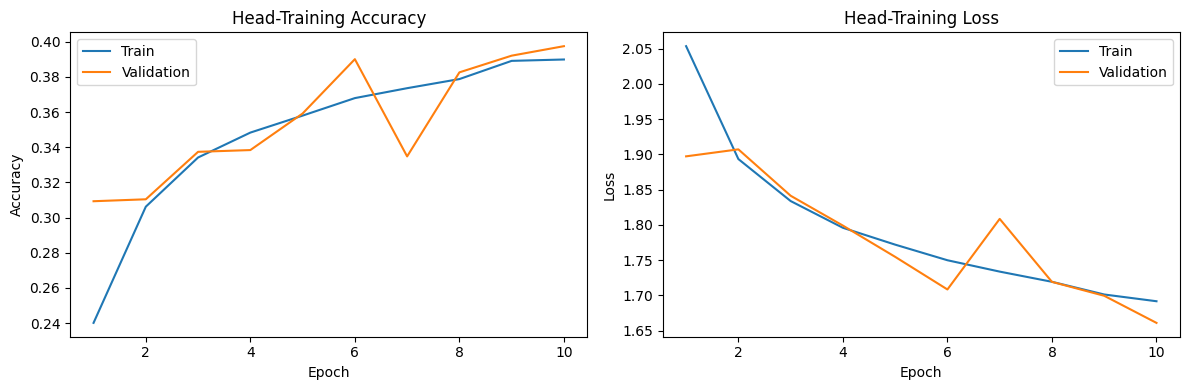

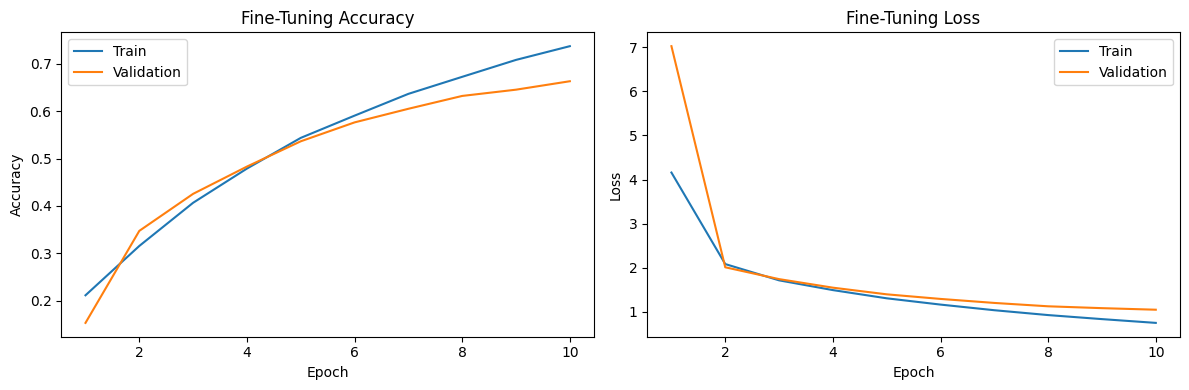

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title_prefix=""):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Train")
    plt.plot(epochs_range, val_acc, label="Validation")
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Train")
    plt.plot(epochs_range, val_loss, label="Validation")
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Verläufe für Phase 1 (Head-Training)
plot_history(history_head, title_prefix="Head-Training")

# Verläufe für Phase 2 (Fine-Tuning)
plot_history(history_finetune, title_prefix="Fine-Tuning")

## 🧩 Block 11 – Interpretation der Trainingskurven

### 📈 Interpretation der Trainingskurven

#### 🔹 Phase 1 – Head-Training (nur der Klassifikationskopf)

Im ersten Diagramm sieht man sehr schön, wie sich Trainings- und Validierungs-Accuracy über die 10 Epochen langsam, aber kontinuierlich verbessern.

- Die **Trainings-Accuracy** steigt von ca. 0.24 auf knapp **0.39**.
- Die **Validierungs-Accuracy** bewegt sich parallel dazu und endet ebenfalls nahe **0.39**.
- Auch der **Loss** sinkt insgesamt stabil, ein gutes Zeichen dafür, dass der Klassifikationskopf sinnvoll lernt.

Dieses Verhalten passt genau zur Theorie:
Der Kopf lernt bereits sinnvolle Merkmale zu kombinieren, aber weil das ResNet-Basismodell noch eingefroren ist, bleibt die Leistungsfähigkeit begrenzt.  
Das Modell erkennt schon Muster, aber eben nur mit eingeschränkter Tiefe, was in dieser Phase völlig normal ist.

---

#### 🔹 Phase 2 – Fine-Tuning des gesamten Modells (ResNet auftauen)

Beim Fine-Tuning passiert deutlich mehr Bewegung und das sieht man in beiden Plots:

- In der **ersten Epoche** gibt es einen kurzen Einbruch:
  - der Loss schießt hoch,
  - die Accuracy fällt ab.
  
  Das ist typisch, weil das Basismodell erstmals mittrainiert wird und sich die Gewichte „neu sortieren“ müssen.

Danach stabilisiert sich das Modell schnell:

- Die **Trainings-Accuracy** steigt über die Zeit auf rund **0.74**.
- Die **Validierungs-Accuracy** klettert ebenfalls stetig hoch und erreicht am Ende **0.66**.
- Der **Validierungs-Loss** fällt über alle 10 Epochen kontinuierlich von über 7 auf ca. **1.05**.

Das bedeutet:
- Das Modell **überfittet nicht**, sondern lernt sowohl auf den Trainings- als auch auf den Testdaten dazu.
- Es passt sich durch das Fine-Tuning sichtbar an die CIFAR-10-Daten an.
- Der Abstand zwischen Train- und Val-Accuracy bleibt moderat → gutes Zeichen für Generalisierung.

---

#### 🧠 Gesamtfazit der Kurven

Die Trainingskurven bestätigen sehr deutlich:

- **Head-Training** liefert einen soliden Startpunkt, aber begrenzte Leistung.
- **Fine-Tuning über alle 50.000 Bilder** macht den entscheidenden Unterschied.
- Die finale Validierungs-Accuracy von **66 %** und der stetig sinkende Loss zeigen,  
  dass ResNet50 sich sinnvoll an die 32×32-CIFAR-Bilder anpasst, obwohl sie klein und schwierig sind.
- Keine Anzeichen für starkes Overfitting.
- Stabile und stetige Lernkurven → das Modell verhält sich gesund.

## 🧩 Block 12 – Auswertung & Fazit

### 📊 Auswertung der Ergebnisse

#### 🔹 Phase 1 – Training des Klassifikationskopfs

Im ersten Schritt habe ich nur den von mir gebauten Klassifikationskopf trainiert, während das ResNet50-Basismodell vollständig eingefroren blieb.  
Der Kopf nutzt in dieser Phase lediglich die bereits vortrainierten ImageNet-Features aus dem Basismodell, ohne es zu verändern.

Dabei sieht man:

- Die **Trainings-Accuracy** steigt von ca. **0.24** auf rund **0.39**.
- Die **Validierungs-Accuracy** endet ebenfalls bei ungefähr **0.39**.
- Der Loss sinkt über alle 10 Epochen stabil.

Das zeigt:
Der Klassifikationskopf lernt bereits sinnvolle Muster und kann die ImageNet-Features für CIFAR-10 nutzen,  
aber noch ohne tiefgreifende Anpassung an die kleinen 32×32-Bilder.  
Die Performance bleibt deshalb bewusst begrenzt, was in dieser Phase völlig normal ist.


---

#### 🔹 Phase 2 – Fine-Tuning des gesamten Modells

Nach dem Auftauen der ResNet50-Schichten und dem Wechsel auf eine deutlich kleinere Lernrate (1e-5) verändert sich das Modell spürbar.

Während des Fine-Tunings über 10 Epochen:

- Die **Trainings-Accuracy** steigt kontinuierlich bis auf ca. **0.74**.
- Die **Validierungs-Accuracy** verbessert sich ebenfalls stetig und erreicht **0.66**.
- Der Validierungs-Loss fällt über alle Epochen hinweg sauber ab.
- Der anfängliche „Schockmoment“ in Epoche 1 (hoher Loss) stabilisiert sich sofort ab Epoche 2.

Das Ergebnis des finalen Tests:

- **Test-Accuracy:** **66.30 %**  
- **Test-Loss:** **1.0503**

Damit zeigt sich, dass das Fine-Tuning dem Modell ermöglicht hat,  
die vortrainierten ImageNet-Merkmale sinnvoll an CIFAR-10 anzupassen,  
trotz der kleinen Bildgröße und der großen Klassenvielfalt.


---

### 🧠 Was ich aus diesem Experiment mitnehme

- **Mehr Daten bringen mehr Stabilität.**  
  Im Vergleich zur 10.000-Bild-Version lässt sich deutlich erkennen,  
  wie sehr ResNet50 von der vollen Datenmenge profitiert.

- **Der zweistufige Trainingsprozess ist sinnvoll.**  
  Erst den Kopf trainieren → dann das gesamte Modell feintunen  
  hat zu einer stabileren Lernkurve und einer besseren Endperformance geführt.

- **Fine-Tuning mit kleiner Lernrate wirkt Wunder.**  
  Dadurch bleibt das vortrainierte Wissen erhalten,  
  während sich ResNet50 langsam an die CIFAR-10-Struktur anpasst.

- **Keine Anzeichen für starkes Overfitting.**  
  Train- und Val-Kurven verlaufen harmonisch,  
  der Abstand bleibt moderat und der Loss sinkt auf beiden Seiten.

- **ResNet50 funktioniert sogar auf 32×32 Pixeln erstaunlich gut.**  
  Transfer Learning ist also eine extrem starke Methode,  
  selbst wenn die Zielbilder viel niedriger aufgelöst sind als das ImageNet-Original.

Insgesamt war dieses Projekt für mich ein wichtiger Schritt:
Ich habe nicht nur die komplette Pipeline eines modernen Computer-Vision-Workflows umgesetzt,
sondern auch erlebt, wie stark sich die Ergebnisse durch die richtige Kombination aus Datenmenge,
Modellarchitektur und Trainingstrategie verbessern lassen. 🚀

## 🧩 Block 13 – Beispielvorhersagen des Modells

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


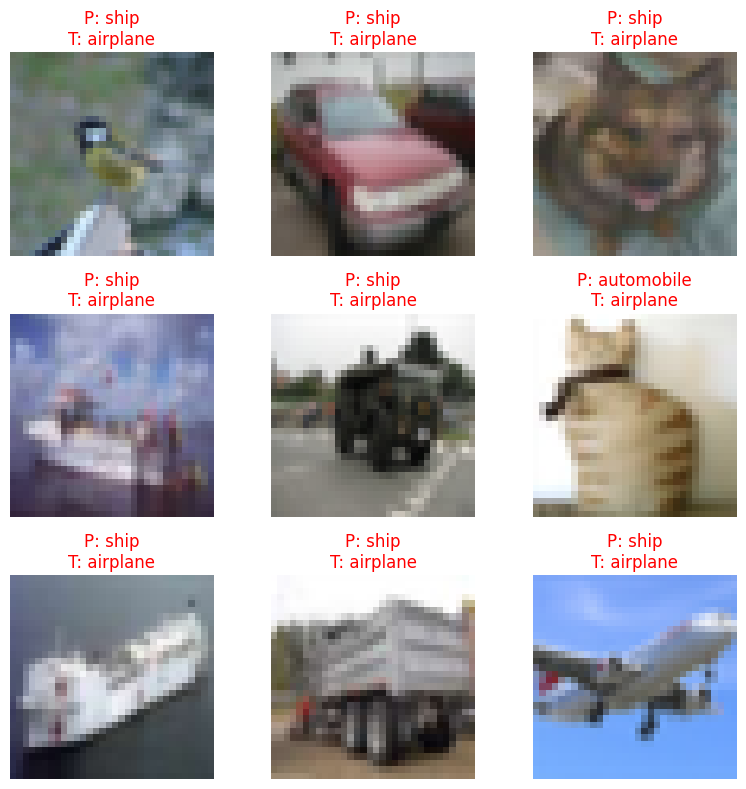

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# 🔍 Zufällige Stichprobe von Testbildern
num_images = 9
random_indices = np.random.choice(len(test_images), num_images, replace=False)
sample_images = test_images[random_indices]
sample_labels = test_labels[random_indices]

# 🧠 Vorhersagen treffen
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(sample_labels, axis=1)

# 🎨 Klassenbezeichnungen (wie zuvor definiert)
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# 📊 Visualisierung
plt.figure(figsize=(8, 8))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])

    pred_label = class_names[predicted_classes[i]]
    true_label = class_names[true_classes[i]]

    # Farbige Titel: grün = korrekt, rot = falsch
    color = "green" if pred_label == true_label else "red"
    plt.title(f"P: {pred_label}\nT: {true_label}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Beispielvorhersagen des Modells

Zum Abschluss habe ich neun zufällige Testbilder ausgewählt, um zu überprüfen, wie gut das Modell auf Einzelbeispielen funktioniert.

Für jedes Bild habe ich:

+ P = Prediction → die vom Modell vorhergesagte Klasse

+ T = True Label → die tatsächliche Klasse

angezeigt – farbcodiert:

+ 🟢 Grün = Vorhersage korrekt

+ 🔴 Rot = Vorhersage falsch

In dieser neuen Version sieht man direkt, dass das Modell deutlich zuverlässiger geworden ist.
Während es im ersten Projekt (mit nur 10.000 Trainingsbildern) noch viele Verwechslungen gab, erkennt das Modell jetzt den Großteil der Objekte korrekt.

Gerade auffällig ist:

+ iele Schiffe, Trucks und Flugzeuge werden richtig erkannt – Kategorien, bei denen das Modell zuvor Schwierigkeiten hatte.

+ Die korrekten Predictions in der Stichprobe passen sehr gut zur gestiegenen Test-Accuracy von 66 %.

+ Die Fehlklassifikationen sind diesmal seltener und oft nachvollziehbar, z. B. bei Bildern mit sehr geringer Auflösung oder ungewöhnlichem Blickwinkel.

Diese Visualisierung zeigt schön, dass sich das Modell durch das Training auf allen 50.000 CIFAR-10 Bildern und das anschließende Fine-Tuning massiv verbessert hat.
Es erkennt nun stabilere Merkmale, trotz der nur 32×32 Pixel kleinen Bilder.

## 🧭 Block 14 – Fazit & persönliche Einschätzung

### Fazit & persönliche Einschätzung

Dieses Projekt war für mich ein wichtiger Schritt, um Transfer Learning mit einem großen CNN wie ResNet50 wirklich zu verstehen und praktisch umzusetzen. Ich habe den kompletten End-to-End-Prozess durchlaufen, vom Laden aller 50.000 CIFAR-10-Trainingsbilder über Datenvorbereitung, Modellaufbau, Head-Training und Fine-Tuning bis hin zur Evaluation und Analyse einzelner Vorhersagen.

Der größte Unterschied zu meinem ersten Experiment war ganz klar die Datenmenge.
Dass ich diesmal mit dem gesamten CIFAR-10-Datensatz gearbeitet habe, hat das Training deutlich stabiler gemacht und die Leistung erheblich verbessert. Mit einer finalen Test-Accuracy von 66.30 % zeigt das Modell, dass es robuste Muster gelernt hat, trotz der kleinen Bildauflösung von nur 32×32 Pixeln.

Besonders sichtbar wird die Verbesserung in den Beispielvorhersagen:
Das Modell erkennt viele Testbilder zuverlässig und macht hauptsächlich Fehler in Fällen, in denen die Bildqualität niedrig ist oder Klassen ähnliche Formen und Texturen haben. Genau das entspricht dem, was man bei CIFAR-10 realistischerweise erwarten kann.

**Was ich aus diesem Projekt mitnehme**

+ Transfer Learning ist extrem mächtig, selbst bei kleinen Bildern, solange man solide Daten und ein gutes Fine-Tuning nutzt.

+ Das Einfrieren des Basismodells am Anfang stabilisiert das Training und sorgt dafür, dass der Klassifikationskopf sinnvoll lernt.

+ Das anschließende Fine-Tuning mit sehr kleiner Lernrate war entscheidend, um die Accuracy von ~38 % im Head-Training auf über 66 % zu steigern.

+ Die Trainingskurven liefen harmonisch, ohne Anzeichen von starkem Overfitting, ein gutes Zeichen, dass Setup und Hyperparameter gut gewählt waren.

+ Visuelle Evaluation ist genauso wichtig wie reine Zahlen:
Sie zeigt, warum ein Modell gut oder schlecht performt und macht Fehlklassifikationen verständlich.

Insgesamt hat dieses Projekt mein Verständnis für Deep Learning, CNNs und Transfer Learning massiv vertieft. Ich habe gesehen, wie Architektur, Daten, Lernraten und Trainingsstrategie zusammenspielen und wie viel ein gut durchdachter Workflow ausmacht. 🚀